In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
from torch import nn
from torch import optim
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, models

In [ ]:
from torch.autograd import Variable
import torch.utils.data as data
import pandas as pd
import os
from PIL import Image
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
import torchvision.transforms.functional as TF

In [ ]:
# Paths for training & validation data. 
# You should create './PatternProject/Train or Validation' folders in your google drive
train_path = '/content/drive/MyDrive/패턴-TermProject/Train/' 
valid_path = '/content/drive/MyDrive/패턴-TermProject/Validation/'


In [ ]:
#Prepare training data set
classes = ['Normal','Fracture']

data =[]
label =[]
resize = transforms.Compose([transforms.CenterCrop(450)]) #crop to 450
# histogram_eq = transforms.Compose([transforms.RandomEqualize(p=0.1)])

count = 0
for i, d in enumerate(classes):
    files = os.listdir(train_path+d)
    files.sort()
    print(len(files))
    for k,f in enumerate(files):
        if k % 10 != 0: 
            path = train_path+d+'/'+f
            img = Image.open(path,'r')
            img = resize(img)
            img2 = TF.hflip(img)
            img3 = TF.vflip(img)
            # img4 = histogram_eq(img)

            r,g,b = img.split() # same levels
            one_img = np.asarray(np.float32(r)/255.0) #choose one
            img = np.asarray([one_img])
            data.append(img)
            label.append(i)

            r,g,b = img2.split() # same levels
            one_img2 = np.asarray(np.float32(r)/255.0) #choose one
            img2 = np.asarray([one_img2])
            data.append(img2)
            label.append(i)

            r,g,b = img3.split() # same levels
            one_img3 = np.asarray(np.float32(r)/255.0) #choose one
            img3 = np.asarray([one_img3])
            data.append(img3)
            label.append(i)

            # r,g,b = img4.split() # same levels
            # one_img4 = np.asarray(np.float32(r)/255.0) #choose one
            # img4 = np.asarray([one_img4])
            # data.append(img4)
            # label.append(i)

            count +=1 


data = np.array(data, dtype='float32')
label = np.array(label, dtype='int64')

train_X = torch.from_numpy(data) #numpy to tensor
train_Y = torch.from_numpy(label)

train_X = train_X.type(torch.cuda.FloatTensor) #32bit
train_Y = train_Y.type(torch.cuda.LongTensor) #For CrossEntropy Loss

train_dataset = TensorDataset(train_X,train_Y)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

177
176


In [ ]:
data.shape

(951, 1, 450, 450)

In [ ]:
label.shape

(951,)

In [ ]:
count

317

In [ ]:
#Prepare validation data set

data =[]
label =[]
count = 0
for i, d in enumerate(classes):
    files = os.listdir(valid_path+d)
    files.sort()
    for k,f in enumerate(files):
        if k % 10 == 0:  
            img = Image.open(valid_path+d+'/'+f,'r')
            img = resize(img)
            r,g,b = img.split()
            one_img = np.asarray(np.float32(r)/255.0)
            img = np.asarray([one_img])
            data.append(img)
            label.append(i)
        
data = np.array(data, dtype='float32')
label = np.array(label, dtype='int64')

valid_X = torch.from_numpy(data)
valid_Y = torch.from_numpy(label)

valid_X = valid_X.type(torch.cuda.FloatTensor)
valid_Y = valid_Y.type(torch.cuda.LongTensor)

valid_dataset = TensorDataset(valid_X,valid_Y)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [ ]:
data.shape

(36, 1, 450, 450)

In [ ]:
label.shape

(36,)

torch.Size([32, 1, 450, 450])
Label = 0 : Normal image


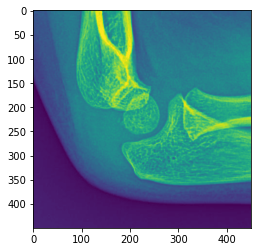

torch.Size([4, 1, 450, 450])
Label = 1 : Fracture image


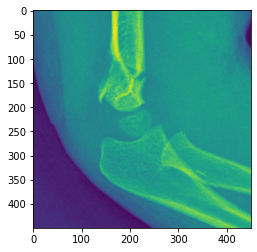

In [ ]:
# Display images
# Not necessary for training. Just for confirmation
for images, labels in valid_loader:
        i, l = Variable(images), Variable(labels)
        print(i.size())
        i = i.cpu().numpy()
        l = l.cpu().numpy()
        if l[0]==0:
            print('Label = {} : Normal image'.format(l[0]))
        else:
            print('Label = {} : Fracture image'.format(l[0]))
        plt.imshow(i[0,0,:,:])
        plt.show()

In [ ]:
'''ref: https://blogofth-lee.tistory.com/264 '''

class VGG(nn.Module):
    def __init__(self, features, num_classes=2, init_weights=True):
        super(VGG, self).__init__()
        
        self.features = features #convolution
        
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        
        self.classifier = nn.Sequential(
            nn.Linear(12544, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x) 
        x = self.avgpool(x)
        x = x.view(x.size(0), -1) 
        x = self.classifier(x) 
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [ ]:
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 1
    
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
                     
    return nn.Sequential(*layers)
    
cfg = {'custom' :[64,'M',128,'M',256,256,'M']}

In [ ]:
model = VGG(make_layers(cfg['custom']), num_classes=2, init_weights=True)
# model.cuda()

In [ ]:
import torchsummary
torchsummary.summary(model, (1, 450, 450),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 450, 450]             640
              ReLU-2         [-1, 64, 450, 450]               0
         MaxPool2d-3         [-1, 64, 225, 225]               0
            Conv2d-4        [-1, 128, 225, 225]          73,856
              ReLU-5        [-1, 128, 225, 225]               0
         MaxPool2d-6        [-1, 128, 112, 112]               0
            Conv2d-7        [-1, 256, 112, 112]         295,168
              ReLU-8        [-1, 256, 112, 112]               0
            Conv2d-9        [-1, 256, 112, 112]         590,080
             ReLU-10        [-1, 256, 112, 112]               0
        MaxPool2d-11          [-1, 256, 56, 56]               0
AdaptiveAvgPool2d-12            [-1, 256, 7, 7]               0
           Linear-13                 [-1, 4096]      51,384,320
             ReLU-14                 [-

In [ ]:
# Print the network you built
model.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
  (classifier): Sequential(
    (0): Linear(in_features=12544, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU(inplace

In [ ]:
# training
def run_train(model):
    model.train()
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(model.parameters(),lr=0.001, momentum=0.9, weight_decay=1e-6)
    optimizer = optim.Adam(model.parameters(),lr=0.0001, weight_decay=1e-5)
    
    total_loss = 0
    correct = 0
    incorrect = 0
    
    for inputs, labels in train_loader:
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        output = model(inputs)
        idx, pred = output.max(1)
        pred = (pred.detach().cpu().numpy())
        truth = (labels.detach().cpu().numpy())
        
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.data.item()
        
        for ix in range(len(pred)):
            if pred[ix] == truth[ix]:
                correct = correct +1
            else:
                incorrect = incorrect +1
        accuracy = (correct/(correct+incorrect))*100
        train_img = inputs.cpu().numpy()
        
    return train_img, pred, truth, accuracy, total_loss

In [ ]:
# Validation
def run_valid(model):
    model.eval()
    criterion = nn.CrossEntropyLoss()
   # optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    total_loss = 0
    correct = 0
    incorrect = 0
    
    for inputs, labels in valid_loader:
        inputs, labels = Variable(inputs), Variable(labels)
        #optimizer.zero_grad()
        output = model(inputs)
        idx, pred = output.max(1)
        pred = (pred.detach().cpu().numpy())
        truth = (labels.detach().cpu().numpy())
        print('Valid_Prediction : {}'.format(pred))
        print('Valid_Truth : {}'.format(truth))
        
        loss = criterion(output, labels)
        total_loss += loss.data.item()
        
        for ix in range(len(pred)):
            if pred[ix] == truth[ix]:
                correct = correct +1
            else:
                incorrect = incorrect +1
        accuracy = (correct/(correct+incorrect))*100
        valid_img = inputs.cpu().numpy()
        
    return valid_img, pred, truth, accuracy, total_loss

***START EPOCH***
# Epoch : 0 /40
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1]
Valid_Truth : [1 1 1 1]
Train Accuracy : 51.629863301787594
Validation Accuracy : 50.0


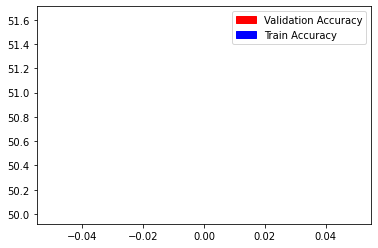

# Epoch : 1 /40
Valid_Prediction : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1]
Valid_Truth : [1 1 1 1]
Train Accuracy : 54.57413249211357
Validation Accuracy : 47.22222222222222


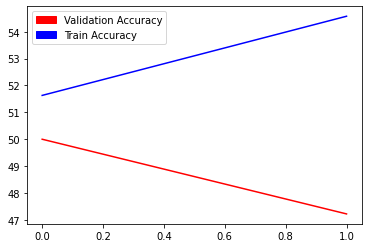

# Epoch : 2 /40
Valid_Prediction : [1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1]
Valid_Truth : [1 1 1 1]
Train Accuracy : 56.15141955835961
Validation Accuracy : 58.333333333333336


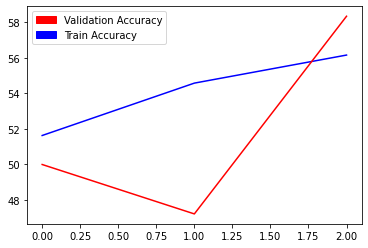

# Epoch : 3 /40
Valid_Prediction : [0 1 1 0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 0]
Valid_Truth : [1 1 1 1]
Train Accuracy : 57.833859095688744
Validation Accuracy : 66.66666666666666


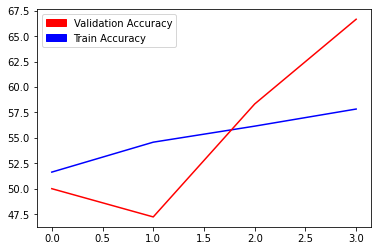

# Epoch : 4 /40
Valid_Prediction : [1 1 1 0 1 1 1 0 0 0 0 1 0 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 0]
Valid_Truth : [1 1 1 1]
Train Accuracy : 59.726603575184015
Validation Accuracy : 63.888888888888886


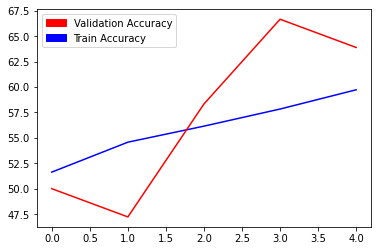

# Epoch : 5 /40
Valid_Prediction : [0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 0 0 0]
Valid_Truth : [1 1 1 1]
Train Accuracy : 56.67718191377497
Validation Accuracy : 58.333333333333336


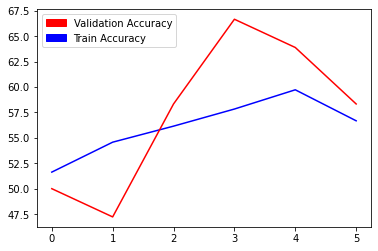

# Epoch : 6 /40
Valid_Prediction : [1 1 1 0 1 1 1 1 0 0 0 1 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 0]
Valid_Truth : [1 1 1 1]
Train Accuracy : 57.93901156677181
Validation Accuracy : 58.333333333333336


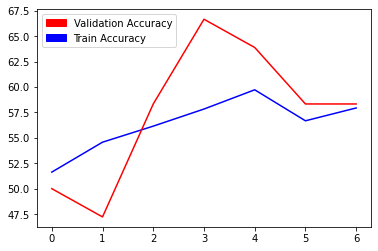

# Epoch : 7 /40
Valid_Prediction : [0 1 1 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 0]
Valid_Truth : [1 1 1 1]
Train Accuracy : 61.72450052576236
Validation Accuracy : 66.66666666666666


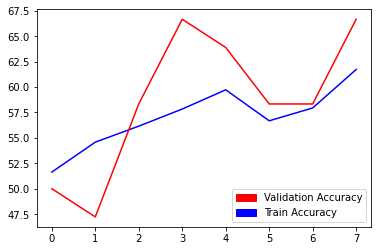

# Epoch : 8 /40
Valid_Prediction : [1 1 1 0 1 1 1 1 0 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1]
Valid_Truth : [1 1 1 1]
Train Accuracy : 61.09358569926393
Validation Accuracy : 66.66666666666666


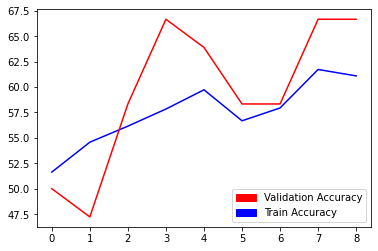

# Epoch : 9 /40
Valid_Prediction : [0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 0 0 0]
Valid_Truth : [1 1 1 1]
Train Accuracy : 61.9348054679285
Validation Accuracy : 63.888888888888886


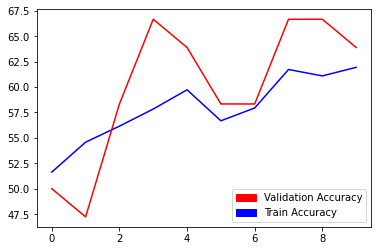

# Epoch : 10 /40
Valid_Prediction : [0 1 1 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 0]
Valid_Truth : [1 1 1 1]
Train Accuracy : 62.9863301787592
Validation Accuracy : 66.66666666666666


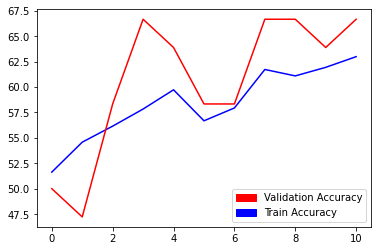

# Epoch : 11 /40
Valid_Prediction : [0 1 1 0 1 1 1 0 0 0 0 1 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 0]
Valid_Truth : [1 1 1 1]
Train Accuracy : 60.462670872765514
Validation Accuracy : 63.888888888888886


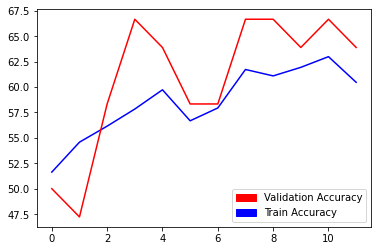

# Epoch : 12 /40
Valid_Prediction : [0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 0 0 0]
Valid_Truth : [1 1 1 1]
Train Accuracy : 63.196635120925336
Validation Accuracy : 63.888888888888886


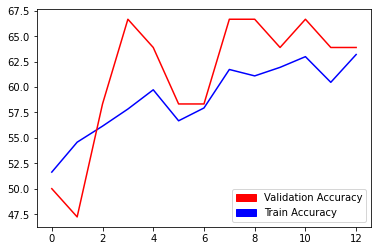

# Epoch : 13 /40
Valid_Prediction : [0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 0]
Valid_Truth : [1 1 1 1]
Train Accuracy : 66.35120925341745
Validation Accuracy : 72.22222222222221


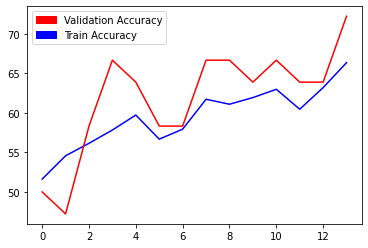

# Epoch : 14 /40
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 0 0]
Valid_Truth : [1 1 1 1]
Train Accuracy : 66.8769716088328
Validation Accuracy : 69.44444444444444


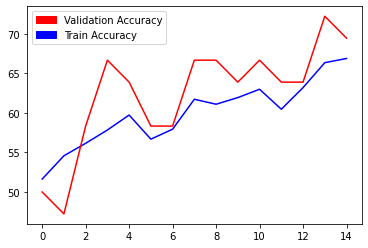

# Epoch : 15 /40
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 0 0 0]
Valid_Truth : [1 1 1 1]
Train Accuracy : 66.35120925341745
Validation Accuracy : 61.111111111111114


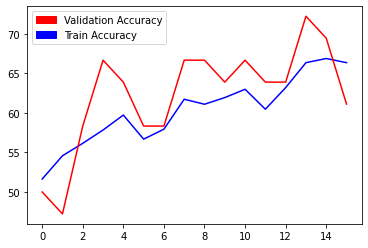

# Epoch : 16 /40
Valid_Prediction : [0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1 0 1 1 1 0 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 0 0]
Valid_Truth : [1 1 1 1]
Train Accuracy : 66.45636172450052
Validation Accuracy : 66.66666666666666


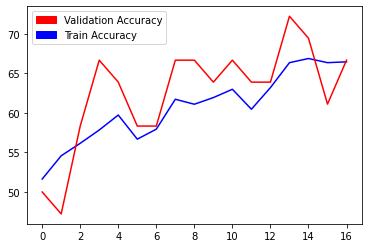

# Epoch : 17 /40
Valid_Prediction : [1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 0]
Valid_Truth : [1 1 1 1]
Train Accuracy : 68.13880126182966
Validation Accuracy : 69.44444444444444


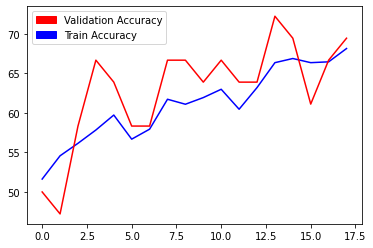

# Epoch : 18 /40
Valid_Prediction : [1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 1 1 0 1 1 1 0 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 0 0 1]
Valid_Truth : [1 1 1 1]
Train Accuracy : 67.71819137749738
Validation Accuracy : 69.44444444444444


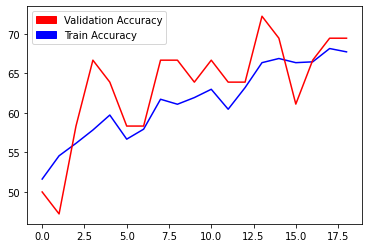

# Epoch : 19 /40
Valid_Prediction : [1 1 1 0 0 0 1 0 1 0 0 1 0 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 0]
Valid_Truth : [1 1 1 1]
Train Accuracy : 68.34910620399579
Validation Accuracy : 66.66666666666666


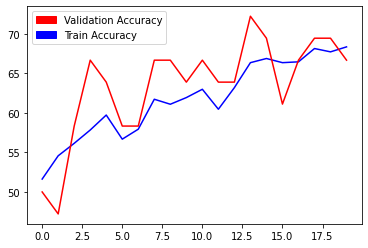

# Epoch : 20 /40
Valid_Prediction : [0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 1 1 0 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 0 0]
Valid_Truth : [1 1 1 1]
Train Accuracy : 70.87276550998949
Validation Accuracy : 69.44444444444444


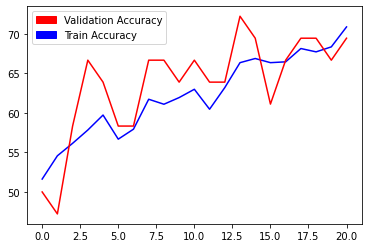

# Epoch : 21 /40
Valid_Prediction : [0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1 0 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 0 0 0]
Valid_Truth : [1 1 1 1]
Train Accuracy : 71.1882229232387
Validation Accuracy : 69.44444444444444


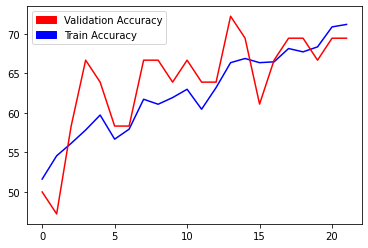

# Epoch : 22 /40
Valid_Prediction : [1 1 1 0 1 1 1 0 1 0 0 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1]
Valid_Truth : [1 1 1 1]
Train Accuracy : 70.34700315457413
Validation Accuracy : 63.888888888888886


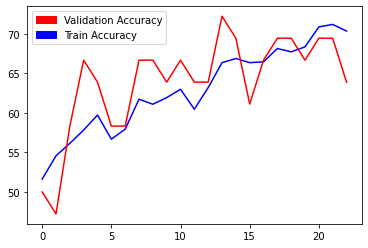

# Epoch : 23 /40
Valid_Prediction : [1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 0 1]
Valid_Truth : [1 1 1 1]
Train Accuracy : 72.45005257623555
Validation Accuracy : 72.22222222222221


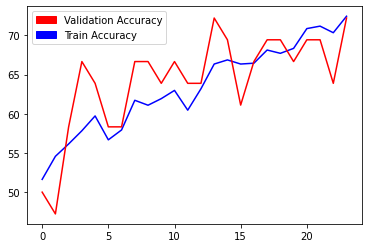

# Epoch : 24 /40
Valid_Prediction : [1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 0 0 1]
Valid_Truth : [1 1 1 1]
Train Accuracy : 73.18611987381703
Validation Accuracy : 72.22222222222221


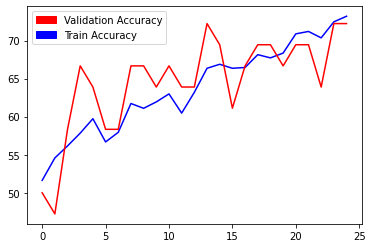

# Epoch : 25 /40
Valid_Prediction : [1 1 1 0 0 0 1 0 1 0 0 1 0 0 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1]
Valid_Truth : [1 1 1 1]
Train Accuracy : 72.2397476340694
Validation Accuracy : 69.44444444444444


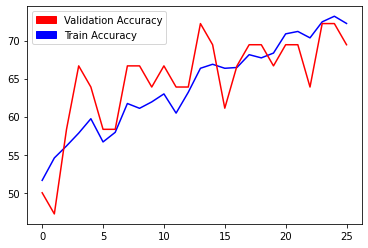

# Epoch : 26 /40
Valid_Prediction : [0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1 0 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 0 0 1]
Valid_Truth : [1 1 1 1]
Train Accuracy : 72.9758149316509
Validation Accuracy : 69.44444444444444


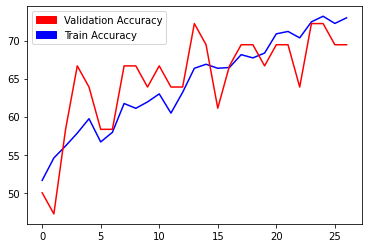

# Epoch : 27 /40
Valid_Prediction : [0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 0 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 0 0 1]
Valid_Truth : [1 1 1 1]
Train Accuracy : 74.44794952681389
Validation Accuracy : 72.22222222222221


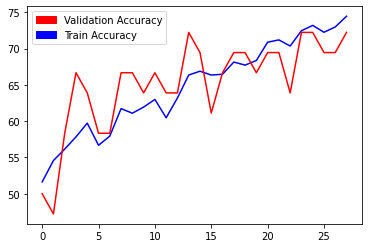

# Epoch : 28 /40
Valid_Prediction : [1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1]
Valid_Truth : [1 1 1 1]
Train Accuracy : 73.08096740273396
Validation Accuracy : 75.0


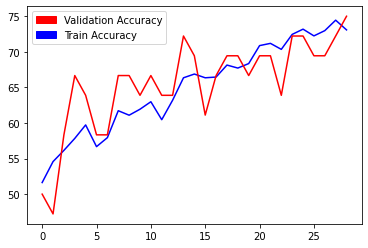

# Epoch : 29 /40
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1 1 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 0]
Valid_Truth : [1 1 1 1]
Train Accuracy : 72.9758149316509
Validation Accuracy : 80.55555555555556


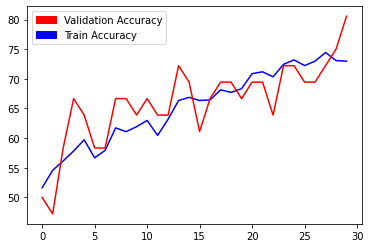

# Epoch : 30 /40
Valid_Prediction : [1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 0 1]
Valid_Truth : [1 1 1 1]
Train Accuracy : 76.13038906414302
Validation Accuracy : 75.0


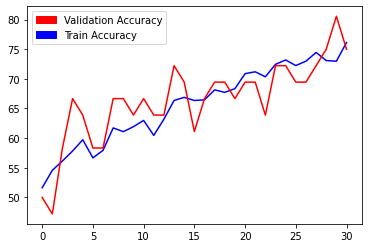

# Epoch : 31 /40
Valid_Prediction : [1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 0 1 1]
Valid_Truth : [1 1 1 1]
Train Accuracy : 76.65615141955836
Validation Accuracy : 75.0


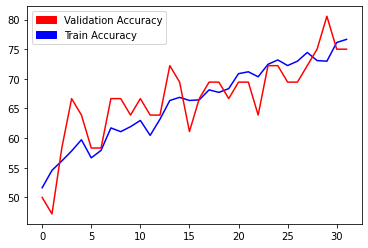

# Epoch : 32 /40
Valid_Prediction : [0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 1 1 1 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 1 1 1]
Valid_Truth : [1 1 1 1]
Train Accuracy : 75.92008412197687
Validation Accuracy : 75.0


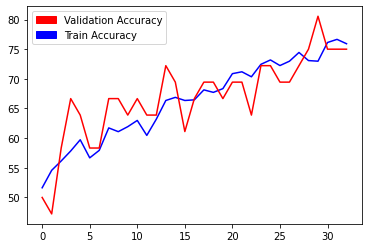

# Epoch : 33 /40
Valid_Prediction : [0 1 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 0 0 1]
Valid_Truth : [1 1 1 1]
Train Accuracy : 77.60252365930599
Validation Accuracy : 69.44444444444444


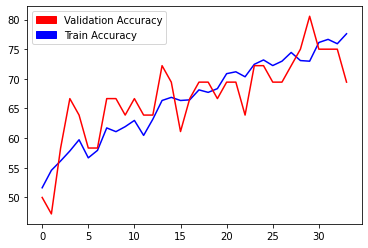

# Epoch : 34 /40
Valid_Prediction : [1 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 0 0 1]
Valid_Truth : [1 1 1 1]
Train Accuracy : 77.70767613038907
Validation Accuracy : 63.888888888888886


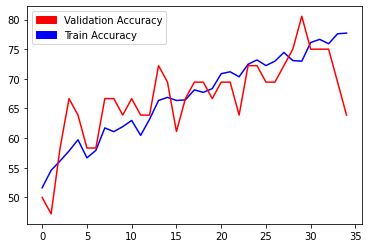

# Epoch : 35 /40
Valid_Prediction : [0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 1 1 0 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 0 1 1]
Valid_Truth : [1 1 1 1]
Train Accuracy : 78.75920084121977
Validation Accuracy : 72.22222222222221


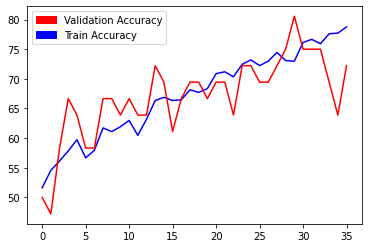

# Epoch : 36 /40
Valid_Prediction : [0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 1 1 0 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 0 0 1]
Valid_Truth : [1 1 1 1]
Train Accuracy : 79.49526813880126
Validation Accuracy : 66.66666666666666


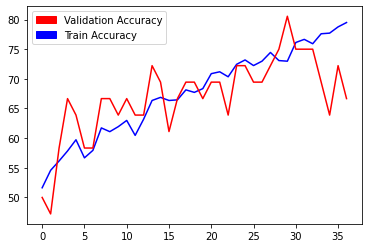

# Epoch : 37 /40
Valid_Prediction : [0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 0 1 0]
Valid_Truth : [1 1 1 1]
Train Accuracy : 80.4416403785489
Validation Accuracy : 80.55555555555556


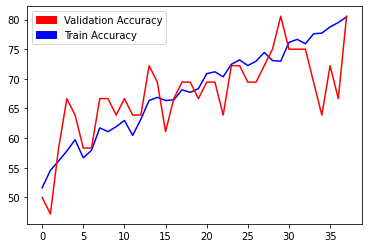

# Epoch : 38 /40
Valid_Prediction : [0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 1 1 1 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 0 1 1]
Valid_Truth : [1 1 1 1]
Train Accuracy : 81.28286014721347
Validation Accuracy : 69.44444444444444


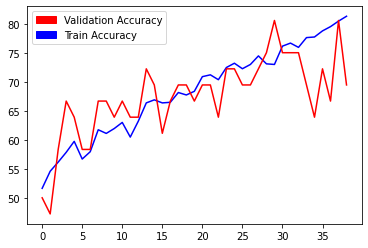

# Epoch : 39 /40
Valid_Prediction : [0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 1 1 0 1 1 0 0 1]
Valid_Truth : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Valid_Prediction : [1 0 0 1]
Valid_Truth : [1 1 1 1]
Train Accuracy : 81.38801261829653
Validation Accuracy : 66.66666666666666


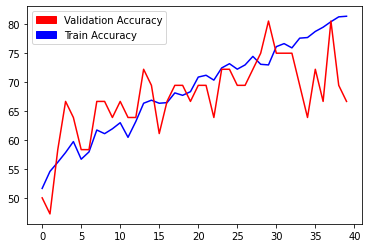

In [ ]:
# Learning
acc_t = []
acc_v = []
print('***START EPOCH***')

for epoch in range(40):
    print('# Epoch : {} /40'.format(epoch))
    train_img, pred_t, truth_t, accuracy_t, loss_t = run_train(model)
    valid_img, pred_v, truth_v, accuracy_v, loss_v = run_valid(model)
    #if epoch%4 == 0:
    print('Train Accuracy : {}'.format(accuracy_t))
    print('Validation Accuracy : {}'.format(accuracy_v))
    acc_t.append(accuracy_t)
    acc_v.append(accuracy_v)

    if max(acc_v) == accuracy_v:
      torch.save(model, '/content/drive/MyDrive/패턴-TermProject/model_0616_2/model_vgg_epoch{}.pth'.format(epoch))
    

    plt.plot(range(len(acc_t)), acc_t, 'b', range(len(acc_v)), acc_v, 'r')
    blue_patch = mpatches.Patch(color='blue', label='Train Accuracy')
    red_patch = mpatches.Patch(color='red', label='Validation Accuracy')
    plt.legend(handles=[red_patch, blue_patch])
    plt.show()

In [ ]:
!nvidia-smi

Tue Jun 15 15:39:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    40W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Save the weight matrices and bias vectors that will be loaded for testing later
torch.save(model,'/content/drive/My Drive/PatternProject/Model_FirstName_IDnumber')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
